In [1]:
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.distributions import Normal
from src.distributions import MIMOFadingAWGNDistribution
from src.capacity_cost.continuous import WassersteinGradientFlowContinuousOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# import logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

torch.manual_seed(10)

# AWGN Channel

We consider the AWGN channel $y=x+n$, where $n\sim\mathcal{N}(0,1)$.

## Quadratic Constraint
We first consider the quadratic constraint for the AWGN channel:
$$
\max_{p(x)} I(X;Y), \quad \text{s. t.} \quad \mathbb{E}[X^2] \leq P.
$$
The result is given by Gaussian input distribution and the capacity is given by
$$
C = \frac{1}{2}\log(1+P/N).
$$

In [2]:
dist_channel = MIMOFadingAWGNDistribution(torch.ones(1,1))
quad_cost_fun = lambda x: (x**2).squeeze()

num_samples_y = 64
num_samples_y_eval = 1024
num_samples_x = 64
# init_x = torch.rand(num_samples_x, 1)
init_x = torch.rand(num_samples_x, 1) - 0.5

optimizer_callable = partial(Adam, lr=1e-2)
# optimizer_callable = partial(SGD, lr=1e-2)
# scheduler_callable = partial(ReduceLROnPlateau, mode='max', patience=200, factor=0.8, threshold=1e-1)
scheduler_callable = None

snr_list = torch.linspace(-10, 20, 20)
# snr_list = [9]

In [ ]:
capacity_list = []
cost_list = []
x_list = []
lam = 0.0

for snr in snr_list:
# for snr in [20]:
    cost_ub = 10**(snr/10)
    init_x = init_x / (quad_cost_fun(init_x).mean() ** 0.5) * (cost_ub ** 0.5)
    
    print(f"SNR: {snr}")
    print(f"Cost UB: {cost_ub}")
    wgf = WassersteinGradientFlowContinuousOutput(dist_channel, num_samples_y, num_samples_y_eval, quad_cost_fun, cost_ub, init_x, optimizer_callable, scheduler_callable, lam, lr_lam=4e-4, eps = 1e-5, max_iter=5000, verbose = 100)
    logs = wgf.run()
    capacity_list.append(logs['rate'][-1])
    cost_list.append(logs['cost'][-1])
    x_list.append(logs['x'])

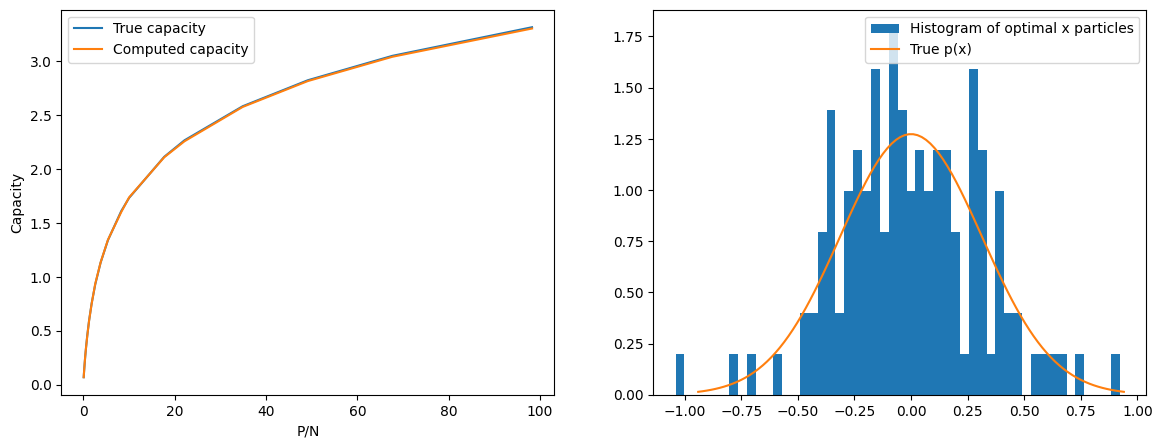

In [22]:
# snr_lin = 10 ** (snr_list / 10)
cost = torch.tensor(cost_list)
snr_lin = cost
capacity_true = 0.5 * torch.log2(1 + cost)
capacity = np.array(capacity_list) * np.log2(np.e)
idx = 0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(snr_lin, capacity_true, label='True capacity')
axes[0].plot(snr_lin, capacity, label='Computed capacity')
axes[0].set_xlabel('P/N')
axes[0].set_ylabel('Capacity')
axes[0].legend()

x = x_list[idx][-1]
sigma = np.sqrt(cost_list[idx])
t = torch.linspace(-3* sigma, 3*sigma, 100)
p = Normal(0, sigma).log_prob(t).exp().numpy()
axes[1].hist(x, bins=50, density=True, label = 'Histogram of optimal x particles')
axes[1].plot(t, p, label='True p(x)')
axes[1].legend()

fig.show()

## Peak Power Constraint

We now consider the peak power constraint for the AWGN channel: $|x|^2\leq P$.
The capacity is attained by discrete input distribution, so we expect that the particles concentrate on some discrete points.
For more details see 

Dauwels, Justin. "Numerical computation of the capacity of continuous memoryless channels." Proceedings of the 26th Symposium on Information Theory in the BENELUX. 2005.
Chan, Terence H., Steve Hranilovic, and Frank R. Kschischang. "Capacity-achieving probability measure for conditionally Gaussian channels with bounded inputs." IEEE Transactions on Information Theory 51.6 (2005): 2073-2088.

In [4]:
dist_channel = MIMOFadingAWGNDistribution(torch.ones(1,1))
# peak power constraint
def peak_cost_fun(x):
    power = (x**2).squeeze()
    return torch.ones_like(power) * power.max()

num_samples_y = 128
num_samples_y_eval = 1024
num_samples_x = 64
lam = 0.25
init_x = torch.randn(num_samples_x, 1)

optimizer_callable = partial(Adam, lr=1e-2)
# optimizer_callable = partial(SGD, lr=1e-1)
# scheduler_callable = partial(ReduceLROnPlateau, mode='max', patience=200, factor=0.8, threshold=1e-1)
scheduler_callable = None

snr_list = torch.linspace(0, 10, 15)

In [ ]:
capacity_list = []
cost_list = []
x_list = []
lam = 0

for snr in snr_list:
    cost_ub = 10**(snr/10).item()
    print(f"Cost upper bound: {cost_ub}")
    # dist_channel = MIMOFadingAWGNDistribution(torch.ones(1,1), sigma_noise = 1.0/np.sqrt(cost_ub))
    wgf = WassersteinGradientFlowContinuousOutput(dist_channel, num_samples_y, num_samples_y_eval, peak_cost_fun, cost_ub, init_x, optimizer_callable, scheduler_callable, lam, lr_lam=0.0001, eps = 0.0, max_iter=8000, verbose = 500)
    logs = wgf.run()
    capacity_list.append(logs['rate'][-1])
    cost_list.append(logs['cost'][-1])
    x_list.append(logs['x'])

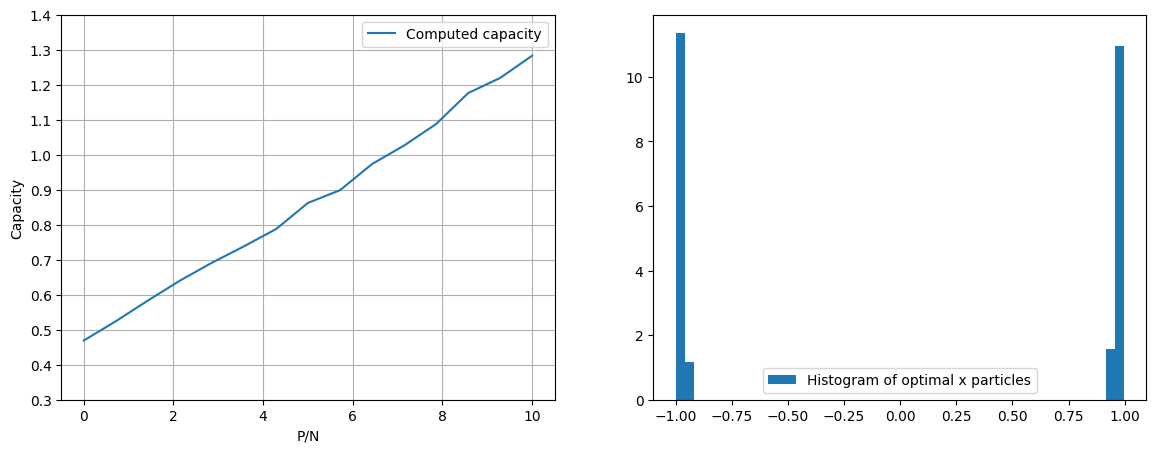

In [8]:
# snr_lin = 10 ** (snr_list / 10)
cost = torch.tensor(cost_list)
snr_lin = cost
capacity = np.array(capacity_list) * np.log2(np.e)
# indx = torch.abs(snr_lin - cost) <= 1
indx = torch.ones_like(snr_lin).bool()
idx = 0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(snr_list[indx], capacity[indx], label='Computed capacity')
axes[0].set_xlabel('P/N')
axes[0].set_ylabel('Capacity')
axes[0].set_yticks(np.arange(0.3,1.41,0.1))
axes[0].grid()
axes[0].legend()

x = x_list[idx][-1]
axes[1].hist(x, bins=50, density=True, label = 'Histogram of optimal x particles')
axes[1].legend()

fig.show()

# MIMO-AWGN

In [6]:
dim_y = 2
dim_x = 2
H = torch.randn(dim_y, dim_x)
Q1, _ = torch.linalg.qr(H)
H2 = torch.randn(dim_y, dim_x)
Q2, _ = torch.linalg.qr(H2)
eigvals = torch.rand(min(dim_y, dim_x))
eigvals = (eigvals / eigvals.sum()) ** 0.5
S = torch.zeros(dim_y, dim_x).diagonal_scatter(eigvals)
H = Q1 @ S @ Q2.T

dist_channel = MIMOFadingAWGNDistribution(channel_mat=H)
# peak power constraint
def quad_cost_fun(x):
    # x: [Nx, dim_x]
    power = (x**2).sum(dim=-1)
    return power

num_samples_y = 64
num_samples_y_eval = 512
num_samples_x = 64
lam = 0.1
# init_x = (torch.rand(num_samples_x, dim_x) -0.5) * 3
# init_x = torch.randn(num_samples_x, dim_x) * 1
init_x = torch.rand(num_samples_x, dim_x) - 0.5

optimizer_callable = partial(Adam, lr=5e-2)
# optimizer_callable = partial(SGD, lr=1e-2)
# scheduler_callable = partial(ReduceLROnPlateau, mode='max', patience=200, factor=0.8, threshold=1e-1)
scheduler_callable = None

snr_list = torch.linspace(6, 20, 20)

In [28]:
eigvals

tensor([0.3050, 0.0623, 0.2308, 0.2610, 0.2145, 0.2246, 0.2942, 0.2950, 0.2307,
        0.1529, 0.2010, 0.3312, 0.1922, 0.1877, 0.2777, 0.3683])

In [ ]:
capacity_list = []
cost_list = []
x_list = []
lam = 0

for snr in snr_list:
# for snr in [10]:
    cost_ub = 10**(snr/10)
    print(f"SNR: {snr}")
    print(f"Cost UB: {cost_ub}")
    init_x = init_x / quad_cost_fun(init_x).mean().sqrt() * cost_ub.sqrt()
    wgf = WassersteinGradientFlowContinuousOutput(dist_channel, num_samples_y, num_samples_y_eval, quad_cost_fun, cost_ub, init_x, optimizer_callable, scheduler_callable, lam=lam, lr_lam=1e-5, max_iter=5000, verbose = 100)
    logs = wgf.run()
    capacity_list.append(logs['rate'][-1])
    cost_list.append(logs['cost'][-1])
    x_list.append(logs['x'])

In [33]:
import cvxpy as cp
#solve the capacity using cvxpy

cov_x_list = []
capacity_true_list = []
for i in range(len(cost_list)):
    cov_x = cp.Variable((dim_x, dim_x), symmetric=True)
    constraints = [cov_x >> 0]
    constraints += [cp.trace(cov_x) <= cost_list[i]]
    obj = cp.Maximize(cp.log_det(torch.eye(dim_x) + H.T @ H @ cov_x) / 2)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    cov_x_list.append(cov_x.value)
    capacity_true_list.append(prob.value)

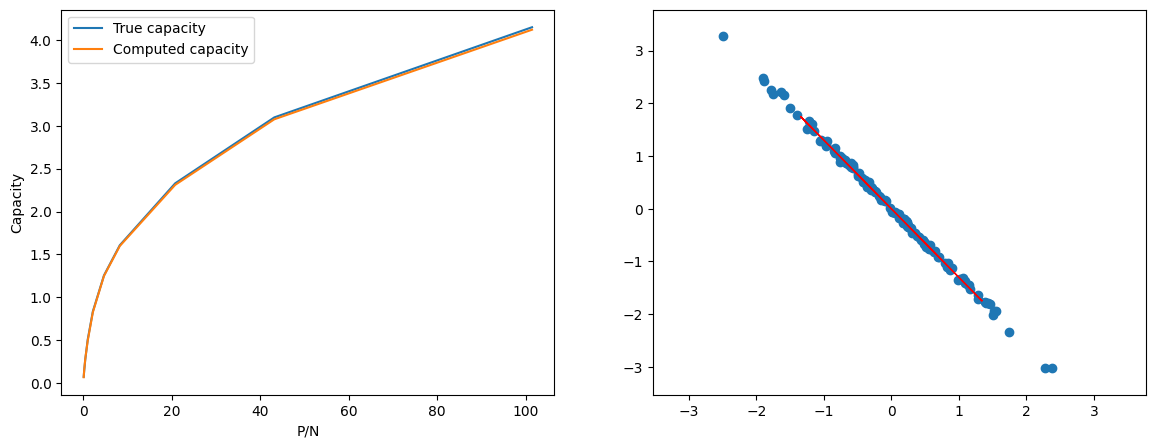

In [51]:
capacity_true = np.array(capacity_true_list) * np.log2(np.e)
capacity = np.array(capacity_list) * np.log2(np.e)
cost = torch.tensor(cost_list)
snr_lin = cost
idx = 4
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot capacity
axes[0].plot(snr_lin, capacity_true, label='True capacity')
axes[0].plot(snr_lin, capacity, label='Computed capacity')
axes[0].set_xlabel('P/N')
axes[0].set_ylabel('Capacity')
axes[0].legend()

# plot the ellipsoid
x = x_list[idx][-1]
import matplotlib.patches as patches
axes[1].scatter(x[:,0], x[:,1])
eigval, eigvec = np.linalg.eigh(cov_x_list[idx])
eigval[eigval < 0] = 0
angle = np.arctan2(eigvec[1,0], eigvec[0,0]) * 180 / np.pi
width, height = 3 * np.sqrt(eigval)
ell = patches.Ellipse((0,0), width, height, angle=angle, fill=False, color='red')
axes[1].add_patch(ell)
axes[1].set_xlim(x.min()-0.5, x.max()+0.5)
axes[1].set_ylim(x.min()-0.5, x.max()+0.5)

fig.show()
